In [48]:
# Imports
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arrow
import numpy as np

# Constants
#colors = [{1:'black', -1:'gray'},{1:'darkred', -1:'pink'}]
colors = {0:'black', 1:'gray', 2: 'blue', -1:'pink', -2:'darkred'}

In [49]:
# Class Definitions
class Marker:
    def __init__(self, type : int, subtype : int, time : int, value : int):
        self.type = type
        self.subtype = subtype
        self.time = time
        self.value = value

# Class Definitions
class PulseBound:
    def __init__(self, start : (int,float), end : (int,float)):
        self.start = start
        self.end = end

# Class Definitions
class PulsePeakBound(PulseBound):
    def __init__(self, start : (int,float), end : (int,float), peak : (int,float)):
        super().__init__(start,end)
        self.peak = peak
        
    def add_to_axis(self,ax):
        x = self.start[0]
        y = self.start[1]
        x_to_peak = self.end[0] - x
        y_to_peak = self.end[1] - y
        arrow = Arrow(x,y,x_to_peak,y_to_peak, edgecolor = "black", width = 0.00001)
        ax.add_patch(arrow)

        arrow = Arrow(self.start[0], self.peak[1], self.end[0] - self.start[0], 0, edgecolor = "red", width = 0.00001)
        ax.add_patch(arrow)

# Class Definitions
class PulseBasic(PulsePeakBound):
    def __init__(self, start : (int,float), end : (int,float), peak : (int,float), steepest_rise : (int,float,float), sharpest_drop : (int,float,float)):
        super().__init__(start,end,peak)
        
        self.steepest_rise = steepest_rise
        self.sharpest_drop = sharpest_drop
    
    def add_to_axis(self,ax):
        super().add_to_axis(ax)
        x = self.steepest_rise[0]
        y = self.steepest_rise[1]
        width = self.sharpest_drop[0] - self.steepest_rise[0]
        height = self.sharpest_drop[1] - self.steepest_rise[1]
        arrow = Arrow(x, y, width, height, edgecolor = "green", width = 0.00001)
        ax.add_patch(arrow)

In [50]:
# Basic Plots
def plot_markers(markers : [Marker], J):
    plt.vlines([marker.time for marker in markers],J[0]/2 + 10,J[1]/2 - 10, colors = [colors[marker.type] for marker in markers])

def plot_bounds(bounds : [PulseBound],J):
    datum = datum[1:]
    start, end = datum[0], datum[1]
    plt.plot()
    plt.vlines([start,end],J[0]/2 + 10,J[1]/2 - 10, colors = ['red', 'black'])
    plt.hlines(J[0]/4 + J[1]/4, start, end)

In [51]:

def plot_gaussian(datum):
    mu = datum[0]
    A = datum[1]
    sigma = datum[2]
    x = np.arange(mu - 100, mu + 100, 0.1)
    y = A*np.exp(-0.5*np.square(x - mu)/(sigma*sigma))
    plt.plot(x, y, linestyle = "dashed")

def plot_biexp_curve(t, kappa, rho):
    return np.exp(-t/kappa) - np.exp(-t/rho)

def plot_biexp(datum):
    datum = datum[1:]
    
    start, end = datum[0], datum[1]
    baseline, amp, kappa, rho = datum[2], datum[3], datum[4], datum[5]
    x = np.arange(start, end, 0.1)
    y = amp*plot_biexp_curve(x - start, kappa, rho) + baseline
    plt.plot(x, y, linestyle = "dashed")

def plot_second_order_cpx(x, A,B,C, param_lambda, param_theta):
    return np.exp(-x*param_lambda)*(A*np.cos(0.5*x*param_theta) + B*np.sin(0.5*x*param_theta)) + C

def plot_second_order(datum):
    datum = datum[1:]
    start, end, _ = datum[0], datum[1], datum[2]
    param_lambda, param_theta = datum[3], datum[4]
    A,B,C = datum[5], datum[6], datum[7]
    x = np.arange(start, end, 0.1)
    y = plot_second_order_cpx(x - start, A, B, C, param_lambda, param_theta)
    plt.plot(x,y, linestyle = "dashed")

In [52]:


# f = open('data/retrace.csv')
# tokens = [e.split(",") for e in f.readlines()]
# x = [int(e[0]) for e in tokens]
# y = [int(e[1]) for e in tokens]
# handle = plt.plot(x,y)

def get_trace_file(filename):
    f = open("../" + filename, 'r')
    tokens = [[float(x) for x in e.split(",")] for e in f.readlines()]
    #tokens = [token for token in tokens if I[0] <= token[0] <= I[1]]
    #maxy = max([e[1] for e in tokens])
    x = [e[0] for e in tokens]
    y = [e[1] for e in tokens]
    return (x,y)

def get_detect_file(filename):
    f = open("../" + filename, 'r')
    tokens = [[float(x) for x in e.split(",")] for e in f.readlines()]
    markers = [Marker(int(token[1]),0,int(token[0]),int(token[2])) for token in tokens]
    return markers

def get_event_file(filename):
    f = open("../" + filename, 'r')
    tokens = [[float(x) for x in e.split(",")] for e in f.readlines()]
    return tokens

In [53]:
def FileToPulseBasics(data : [[float]]) -> [PulseBasic]:
    return [
        PulseBasic(
            (datum[0],datum[1]),
            (datum[2],datum[3]),
            (datum[4],datum[5]),
            (datum[6],datum[7],datum[8]),
            (datum[9],datum[10],datum[11])
        ) for datum in data
    ]

In [54]:
def create_trace_plot(ax,data,I,J):
    plt.subplot(ax)
    plt.xlim(I)
    #plt.ylim(J)
    plt.plot(data[0],data[1])

def create_event_plot(ax,data,I,J):
    plt.subplot(ax)
    plt.xlim(I)
    plt.ylim(J)
    plt.subplot(ax)
    for datum in data:
        plot_bounds(datum,J)
        plot_second_order(datum)

def create_basic_plot(ax,data,I,J):
    plt.subplot(ax)
    plt.xlim(I)
    plt.ylim(J)
    plt.subplot(ax)
    for basic in FileToPulseBasics(data):
        basic.add_to_axis(ax)

In [55]:

def create_plot(data, I):
    fig = plt.figure(figsize = (14,12))
    ax = plt.subplot(2,1,1)
    ax.patches.clear()
    maxy = max(data[0][1])
    miny = min(data[0][1])
    J = (miny,maxy)
    create_trace_plot(ax,data[0],I,J)
    create_trace_plot(ax,data[1],I,J)
    create_basic_plot(ax,data[2],I,J)

    return fig,ax

In [56]:
from ipywidgets import interact, widgets

data = [get_trace_file('Saves/output_baselined.csv'),
        get_trace_file('Saves/output_smoothed.csv'),
        get_event_file('Saves/output_pulses.csv')]

def func(delta, size):
    I = (delta,delta + size)
    fig,ax = create_plot(data,I)

interact(func,
    delta = widgets.IntSlider(min=0, max=30000, step=100, value=3000),
    size = widgets.IntSlider(min=100, max=25000, step=100, value=300)
)

interactive(children=(IntSlider(value=3000, description='delta', max=30000, step=100), IntSlider(value=300, de…

<function __main__.func(delta, size)>

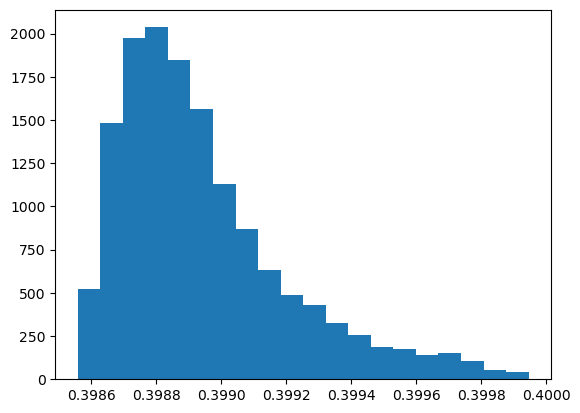

In [80]:
times = [pulse.peak[1]
            for pulse in FileToPulseBasics(get_event_file('Saves/output_all_pulses.csv'))
                if pulse.peak[1] > 0.3985 
        ]
values, edges, _, = plt.hist(times, bins = 20, density = True, log = False)


[[4.91227215e-08 1.32951869e-09]
 [1.32951869e-09 3.69810331e-11]]
[0.00426914 0.0003552 ]
2.2522718299895503e-06


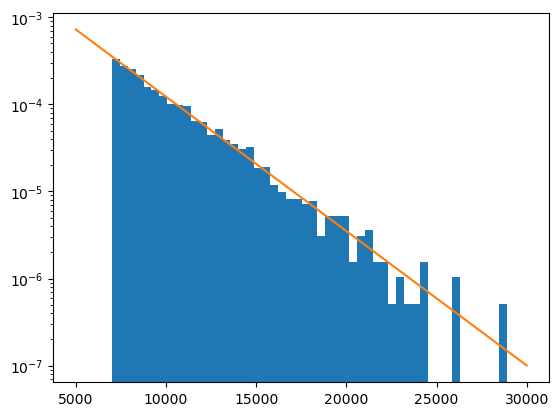

In [85]:
times = [pulse.steepest_rise[0]
            for pulse in FileToPulseBasics(get_event_file('Saves/output_all_pulses.csv'))
                if pulse.start[0] > 7000 and pulse.end[0] < 30000 and pulse.peak[1] > 0.3985
        ]
values, edges, _, = plt.hist(times, bins = 50, density = True, log = True)

from scipy.optimize import curve_fit
def func(x, a, b):
    return a*np.exp(-b*x)

pos = np.array([(e1 + e2)/2 for (e1,e2) in zip(edges[:-1],edges[1:])])

popt, pcov = curve_fit(func, pos, values, p0 = (1.0,0.0))
print(pcov)
print(popt)
print(8e-10/popt[1])

X = np.linspace(5000,30000)
plt.plot(X,func(X, *popt))